In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

<h1>To do:</h1>
<p>Add function to scale line width according to numbers of genes affected.</p>

In [200]:
def compare_profiles(dats1, dats2, dats1_columns = ['ORF','RNA_Prints','Ribo_Prints'],
                     dats2_columns = ['ORF','RNA_Prints','Ribo_Prints'],colors =['red','green','black'],return_df=False,linewidth_value = 'proportion'):
    
    """Computes and displays the predominant movements of transcripts between polysome peaks for two conditions."""
    
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    
    def counts_to_RPKM(dats):
        #read in the gene length info dataset
        genes = pd.read_csv('Data/sacCer3 genes.csv')
        #combine input dataset with gene length information 
        dats = dats.merge(genes[['name','length']],how='inner',left_on='ORF',right_on='name')[['ORF','RNA_Prints','Ribo_Prints','length']]
        #calculate RPKM
        dats['RNA_RPKM'] = dats['RNA_Prints']/(dats['length']/1000) 
        dats = dats.drop(['RNA_Prints','length'],axis=1)
        return dats
    
    def calc_RperR(Rdats, RNA_content = 60000, ribo_content = 200000, frac_act = 0.85,poly_limit = 30):
        #determine conversion factor from Ribo_Prints to no of Ribosomes
        RiboPrints2Ribos = (ribo_content * frac_act) / sum(Rdats['Ribo_Prints'])
        Rdats['Ribos_bound'] = Rdats['Ribo_Prints']*RiboPrints2Ribos
        #determine conversion factor from RNA_RPKM to no of RNAs
        RNARPKM2RNAs = RNA_content / sum(Rdats['RNA_RPKM'])
        Rdats['RNAs_per_cell'] = Rdats['RNA_RPKM']*RNARPKM2RNAs
        #calculate the ribosome load per RNA (RperR)
        Rdats['RperR'] = np.round(Rdats['Ribos_bound'] / Rdats['RNAs_per_cell'])
        Rdats=Rdats.dropna()
        #remove rows where the number of ribosomes per RNA is > poly_limit
        Rdats = Rdats.loc[Rdats['RperR'] <= poly_limit]
        return Rdats
    
    #prepare datasets and compute RperR values via RNA RPKM values
    dats1 = dats1[dats1_columns]
    dats1.columns = ['ORF','RNA_Prints','Ribo_Prints']
    dats1 = counts_to_RPKM(dats1) 
    dats1 = calc_RperR(dats1)
    dats2 = dats2[dats2_columns]
    dats2.columns = ['ORF','RNA_Prints','Ribo_Prints']
    dats2 = counts_to_RPKM(dats2)
    dats2 = calc_RperR(dats2)
    
    #compute column movements for individual transcripts
    fromto = dats1[['ORF','RperR']].merge(dats2[['ORF','RperR']],how = 'inner',on = 'ORF')
    fromto.columns = ['ORF','from','to']
    
    #calculate main destinations for each origin peak
    from_vec = fromto['from'].unique()
    from_vec.sort()
    to_vec = np.zeros(len(from_vec))
    color_vec = []
    linewidth_vec = []
    for idx in range(len(from_vec)):
        this_from  = fromto.loc[fromto['from'] == from_vec[idx]]
        n_seqs_in_peak = this_from.shape[0]
        to_vec[idx] = this_from['to'].value_counts().idxmax()
        n_seqs_to_dest = this_from['to'].value_counts().values[0]
        if from_vec[idx] < to_vec[idx]:
            color_vec.append(colors[1])
        elif from_vec[idx] > to_vec[idx]:
            color_vec.append(colors[0])
        else:
            color_vec.append(colors[2])
        if linewidth_value == 'proportion':
            linewidth_vec.append(1/-np.log(n_seqs_to_dest/n_seqs_in_peak-0.13))
        else:
            linewidth_vec.append(np.log(n_seqs_to_dest))
        
    
    #prepare main figure
    fig,ax = plt.subplots(1,2,figsize = (7,4),sharey=True,gridspec_kw={'width_ratios': [5, 2]})
    for idx in range(len(from_vec)):
        ax[0].plot([from_vec[idx],to_vec[idx]],[3,1],c=color_vec[idx],linewidth=linewidth_vec[idx],alpha=0.4)
    ax[0].set_yticks([3,1])
    ax[0].set_yticklabels(['origin peak','destination peak'])
    ax[0].set_xlabel('Polysome number')
    
    #prepare legend for line width
    if linewidth_value=='proportion':
        ax[1].text(1,2,'Proportion of mRNAs in predominant group',verticalalignment='center',rotation = 90)
        ref_widths = [0.3,0.6,0.9]
        log_ref_widths = [1/-np.log(w-0.13) for w in ref_widths]
    else:
        ax[1].text(1,2,'Number of mRNAs in origin group',verticalalignment='center',rotation = 90)
        ref_widths = [10,100,1000]
        log_ref_widths = [np.log(w) for w in ref_widths]
        
    y_pos = [1.5,2,2.5]
    ax[1].axis('off')
    ax[1].set_xlim((0,1.2))
    for idx in [0,1,2]:
        ax[1].plot([-0.2,0.5],[y_pos[idx],y_pos[idx]],linewidth=log_ref_widths[idx],c='black',alpha=0.4)
        ax[1].text(0.6,y_pos[idx],str(ref_widths[idx]),verticalalignment='center')
    
    if return_df:
        return fig,ax,fromto
    else:
        return fig,ax

In [199]:
w=1
1/-np.log(w-0.13)

7.180706269462305

In [192]:
1/-np.log(0.9-0.2)

9.491221581029905

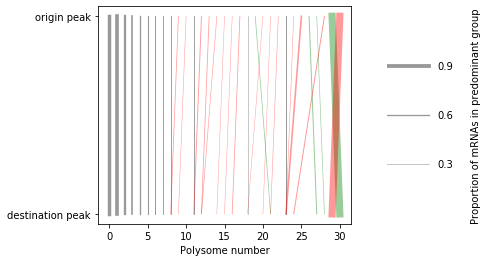

In [203]:
dats = pd.read_csv('Data/GSE67387_all_data.csv')
fig,ax = compare_profiles(dats1 = dats,dats2 = dats,dats1_columns = ['ORF','WT_RNA','WT_Ribo'],dats2_columns = ['ORF','ncs2_RNA','ncs2_Ribo'])
#plt.savefig('Peak_Comparison.svg')
plt.show()

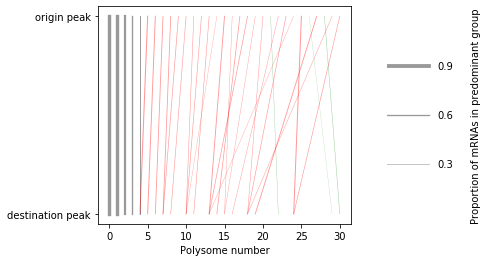

In [204]:
dats = pd.read_csv('Data/GSE67387_all_data.csv')
fig,ax = compare_profiles(dats1 = dats,dats2 = dats,dats1_columns = ['ORF','WT+rapamycin_RNA','WT+rapamycin_Ribo'],dats2_columns = ['ORF','ncs2+rapamycin_RNA','ncs2+rapamycin_Ribo'])
#plt.savefig('Peak_Comparison.svg')
plt.show()

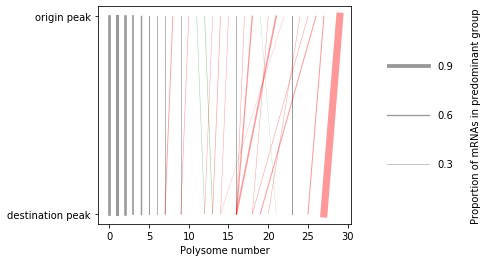

In [206]:
dats = pd.read_csv('Data/GSE67387_all_data.csv')
fig,ax = compare_profiles(dats1 = dats,dats2 = dats,dats1_columns = ['ORF','WT+diamide_RNA','WT+diamide_Ribo'],dats2_columns = ['ORF','ncs2+diamide_RNA','ncs2+diamide_Ribo'])
#plt.savefig('Peak_Comparison.svg')
plt.show()

In [147]:
print(n_seqs_in_peak,n_seqs_to_dest)

12 3


In [167]:
np.min([1,2,3])

1

In [148]:
this_from

,ORF,from,to
535,YCL061C,15.0,13.0
774,YDL160C,15.0,16.0
1240,YDR406W,15.0,18.0
1552,YER111C,15.0,13.0
1566,YER125W,15.0,16.0
2461,YHR158C,15.0,15.0
2665,YIL149C,15.0,14.0
2911,YJL207C,15.0,16.0
3262,YKL203C,15.0,14.0
4558,YNL271C,15.0,15.0


In [162]:
this_from['to'].value_counts()

7.0     33
8.0     24
9.0      8
6.0      6
11.0     2
12.0     1
5.0      1
Name: to, dtype: int64